# Notebook for Determining Global Variables

__About:__  
The most challenging and most influential step in the data processing is the center finding. Use this notebook to optimize the global variables that are used in both the center finding algorithm including `CENTER_GUESS`, `RADIUS_GUESS`, `DISK_RADIUS`, and `THRESHOLD` and the masking algorithm including `MASK_CENTER`, `MASK_RADIUS`, and `ADDED_MASK`  
  
 __!! Each time you change a global variable, restart your kernel and rerun the following code blocks until you're happy with the result !!__

## Global Variable Usage
The package `gued.py` relies on a few global variables which should be optimized for each experiment. The global variables are stored in `gued_globals.py` and follow standard formatting of all caps (i.e., CENTER_GUESS = (470, 450)). 

In [1]:
%%writefile gued_globals.py
### Global Variables for s1 data set

# Variable for reading files
SEPARATORS = ['-', '_']

# Variables for Center Finding Algorithm
CENTER_GUESS = (465, 475)
RADIUS_GUESS = 35
DISK_RADIUS = 3
THRESHOLD = 150

# Variable for Generating Background
CORNER_RADIUS = 20
CHECK_NUMBER = 50

# Variables for Masking
MASK_CENTER = [475, 475]
MASK_RADIUS = 40
ADDED_MASK = [[440, 435, 30], [460, 450, 30]]

# Used throughout code as the threshold for cutting out date. This is the default value but other values can be set for the functions using
# std_factor = 4
STD_FACTOR = 3

# Specifies the maximum number of workers to be used when running concurrent.futures
MAX_PROCESSORS = 6

# Adjust figure size 
FIGSIZE = (12,4)

# Path for Theory Package

PATH_DCS = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\Coding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/ding Lab Notebook\\gued_package\\GUED_Analysis\\packages\\dcs_repositiory\\3.7MeV\\'
#path_dcs = '/sdf/home/l/lheald2/GUED/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/


Overwriting gued_globals.py


## Import Packages

In [2]:
# Standard Packages
import numpy as np
import glob
import matplotlib.pyplot as plt
import random


# new code 
import gued

#interactive plotting 
%matplotlib widget

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [3]:
data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180823\\Run\\*\\'
#data_path = 'C:\\Users\\laure\\OneDrive - University of Nebraska-Lincoln\\Documents\\Centurion Lab\\nitrophenyl code\\20180623\\Run\\'
run_path = "*\\*\\ANDOR1_*.tif"

full_path = data_path + run_path
#full_path = "D:\\UED_Data\\CP Images\\ANDOR1_*.tif"
print(full_path)

files = glob.glob(full_path) 

print(len(files))


C:\Users\laure\OneDrive - University of Nebraska-Lincoln\Documents\Centurion Lab\nitrophenyl code\20180823\Run\*\*\*\ANDOR1_*.tif
1998


### Reading in All Data and Getting Total Counts -- Lauren's Version

In [4]:
help(gued.get_image_details)

Help on function get_image_details in module gued:

get_image_details(file_names, sort=True, filter_data=False, plot=False)
    Reads all images from input file_names and returns the data as a 3d array along with stage positions, order, and counts per image.
    
    ARGUMENTS:
    
    file_names (list):
        list of file names to be read in
    
    OPTIONAL ARGUMENTS:
    
    sort (boolean): 
        default is set to True. This arguments sorts the data based on when it was saved (i.e. file number)
    plot (boolean): 
        default is set to False. When True, a plot of the data, log(data), and histogram of counts is shown
    filter_data (boolean or list): 
        default is set to False. If you want to select only a fraction of the images, set filter_data = [min_image,]
    
    GLOBAL VARIABLES:
    
    SEPARATORS (list):
        list of strings such as '_' or '-' which are used in the file naming scheme to separate values needed for data analysis (i.e. stage
        posi

Takes ~ 30 seconds for 2000 images

Loading diffraction signal


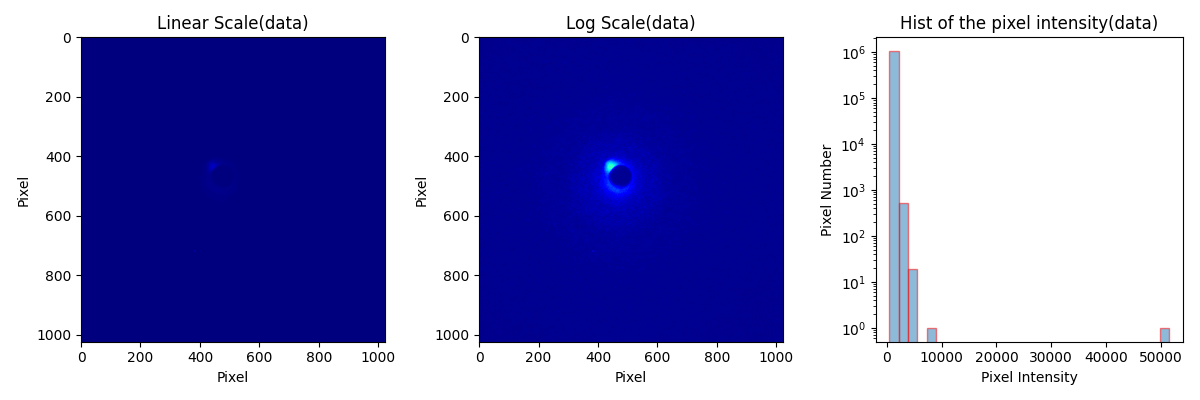

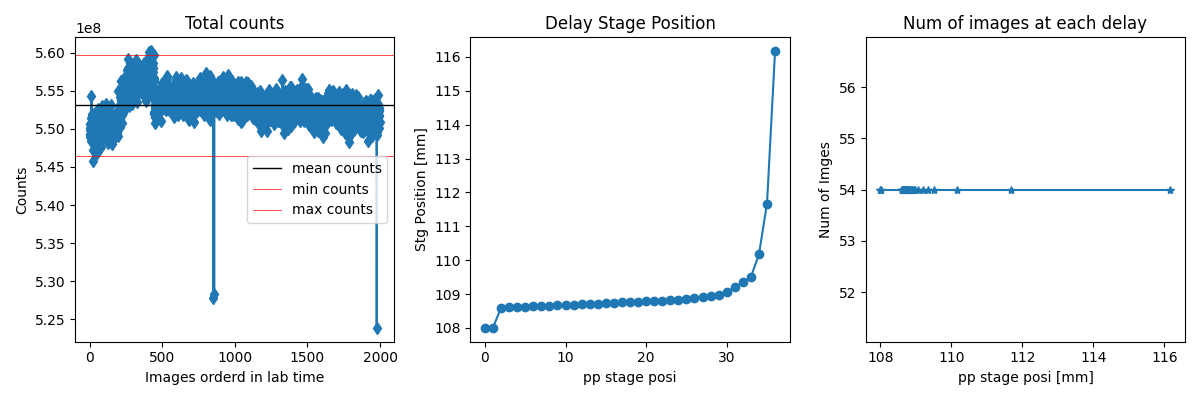

In [5]:
print('Loading diffraction signal')
data_array, stage_positions, file_numbers, counts = gued.get_image_details(files[:], sort=True, filter_data=False, plot=True)


## Create Test Set of Images and process

Need to do these steps so that variables can be used in the fast analysis notebook

In [6]:
file_numbers = list(range(len(data_array)))
rand_idx = random.sample(file_numbers, 50) 
print(np.array(rand_idx))
data_array = data_array[rand_idx]
print("Removing background")
data_array = gued.remove_background_pool(data_array)
print("Removing xrays")
data_array = gued.remove_xrays_pool(data_array, plot=False)

[1566 1404  163 1111  775 1157 1112 1414 1440   78  946  884  549  725
  470 1271 1267  942 1932 1689 1614 1655 1353  758  888 1433 1071 1875
  684 1314  792 1429 1997 1378 1245 1539  249  408 1058  307  510   72
  943 1708 1822  419  111   27 1439  168]
Removing background
Removing xrays
Removing hot pixels from all data


## Find Areas to Mask

In [7]:
help(gued.apply_mask) # for one image, used this function

Help on function apply_mask in module gued:

apply_mask(data_array, fill_value=nan, add_rectangular=False, plot=False, print_vals=False)
    Applies a mask to individual images in the data array.
    
    ARGUMENTS:
    
    data_array: 2D array
        Diffraction pattern.
    
    OPTIONAL ARUGMENTS:
    
    fill_value : int, float, or nan, optional
        Value that use to fill the area of the mask. The default is np.nan.
    add_rectangular : boolean, optional
        Additional mask with rectangular shape. The default is True.
    showingfigure : boolean, optional
        Show figure of the result of applied masks. The default is False.
    
    GLOBAL VARIABLES:
    
    MASK_CENTER : 1D array, tuple, or list that contains only two values
        Center for generating mask cover unscattered electron beam.
    MASK_RADIUS : int
        Radius of the mask.
    ADDED_MASK : list of 3-value-lists, optional
        Additional masks. Input gonna be [[x-center, y-center, radius], [...

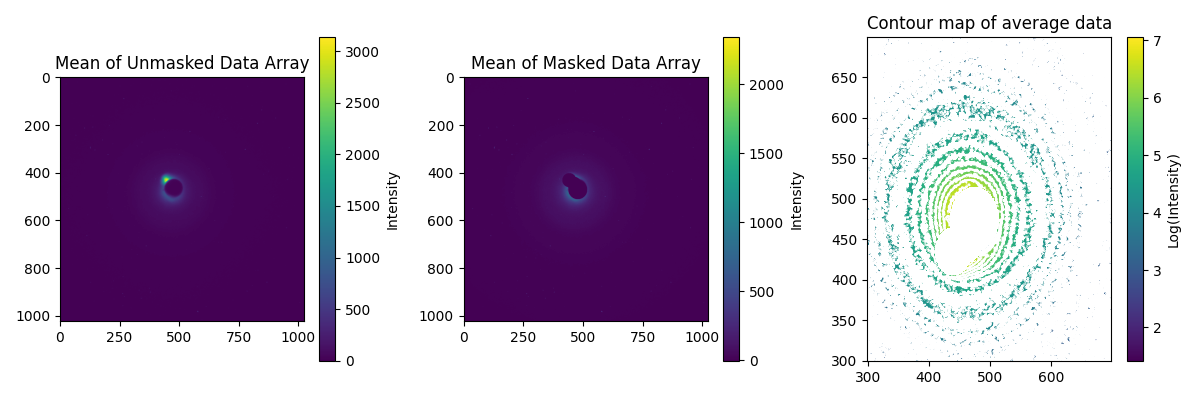

In [8]:
data_array = gued.apply_mask(data_array, fill_value=0.0, plot=True)

## Finding Diffraction Center

In [9]:
help(gued.finding_center_alg) # for one image use this function

Help on function finding_center_alg in module gued:

finding_center_alg(image, thresh_input=150, plot=False, title='Reference Image')
    Algorithm for finding the center of diffraction pattern
    
    ARGUMENTS:
    
    data_array : 2D array
        Diffraction pattern.
    
    OPTIONAL ARGUMENTS:
    
    thresh_input (float):
        Default set to 0. When zero, the threshold value is calculated using threshold_otsu from scikit-images. Often doesn't work
    plot : boolean, optional
        Show figure of the result of center finding. The default is False.
    title : str, optional
        Title of the figure. The default is 'Reference image'.
    
    
    GLOBAL VARIABLES:
    
    DISK_RADIUS : int, optional
        Generates a flat, disk-shaped footprint. The default is 3.
    CENTER_GUESS : tuple contains 2 values, optional
        Guessing center position to generate temporary mask. The default is (532, 520).
    RADIUS_GUESS : int, optional
        Guessing radius of the t

### Find Average Center

Adjust the `THRESHOLD` value then update the `gued_globals.py` file and restart code

In [10]:
# First, check the threshold value being calculated by the code, a good value is usually close to 100
from skimage.filters import threshold_otsu
for data in data_array:
    print(threshold_otsu(data))

6964.262367571717
12.56370672399921
94.83261819897702
108.20740009523166
20.26293889932723
101.37566839814937
111.81940856469416
116.98624424242078
17424.855878474955
81.52837734584617
102.91796243454517
17308.218923703207
15508.662326215388
118.87239276699341
3189.2271116297334
104.829411639577
109.05113693927902
123.3448819528222
18937.890740327908
16116.490755213741
13112.990493956218
121.11649300820316
14837.161629354778
84.79900300355892
117.49074763597984
13831.292753905032
9630.72783984834
70.46724291052908
14845.477165999833
106.95428798692713
4193.6574865489965
7675.130240983074
108.08527536026236
103.88959805415482
104.48282745004836
100.5223196290661
115.77239544691363
127.63460950584548
111.6451984961128
9855.913937398951
18.555427510161884
5967.174389654136
10733.721233162029
19517.226583435797
107.33765418133126
141.58199113544515
17005.085443946242
12.950128124095023
5821.71271801072
106.57184860482096


In the left most graph below, you want the yellow to look circular at the smallest radius possible so adjust `THRESHOLD` value to minimize radius values and minimize range of found center values

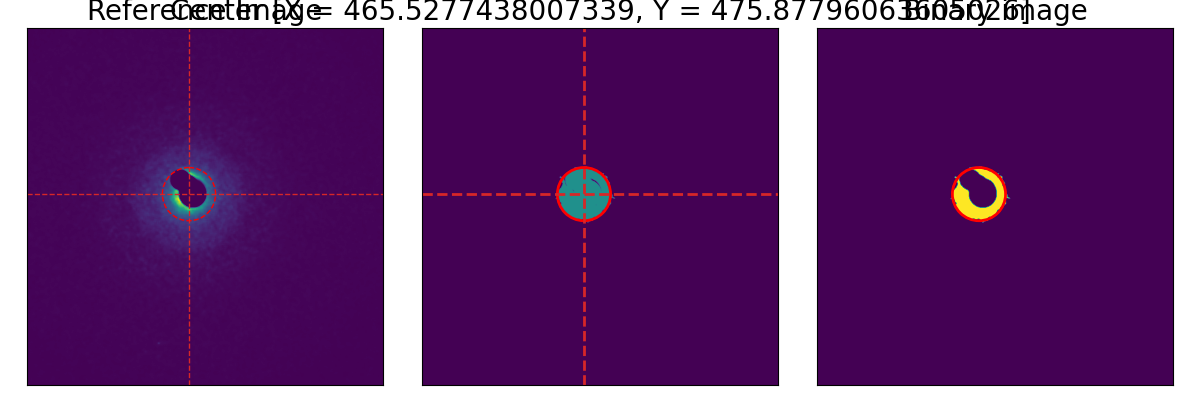

465.5277438007339 475.87796063605026


In [11]:
center_x, center_y, _, _ = gued.finding_center_alg(data_array[0], plot=True)
print(center_x, center_y)

### Find all centers 

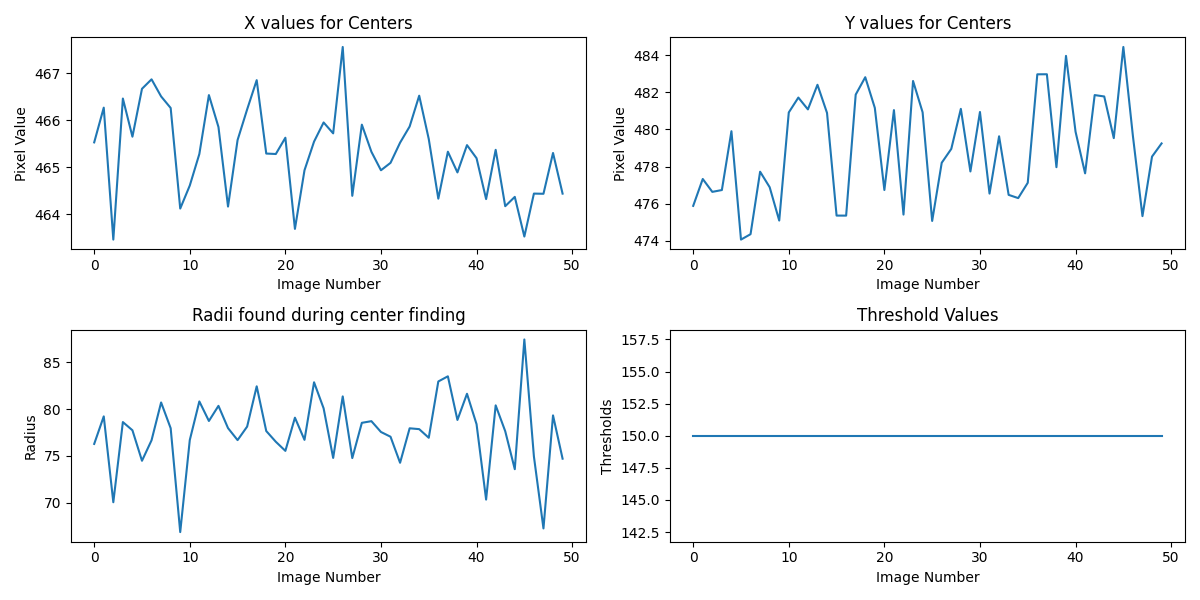

Averaged ctr is (np.float64(465.3436683179121), np.float64(478.97558758417966))
Percentage of images where the center finding failed (i.e., found the guess value): 0.0


In [12]:
center_x, center_y = gued.find_center_pool(data_array, plot=True)

Now you can run the `Fast_Analysis.ipynb` notebook with the optimized global variables. 